# Proyek Klasifikasi Gambar: [Animals-10 Dataset]
- **Nama:** Sandy Tirta Yudha
- **Email:** Sandy Tirta Yudha
- **ID Dicoding:** MC120D5Y2449

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import random
from random import sample
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [2]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (Dense, Dropout, Flatten, BatchNormalization,
                                     Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras import layers

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [5]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:
!kaggle datasets download -d alessiocorrado99/animals10 --quiet

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0


In [7]:
zip_file_path = 'animals10.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

os.remove(zip_file_path)

In [8]:
!ls -l ~/.kaggle/
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 68 May  4 06:47 kaggle.json
{"username":"sandyytirtaa","key":"dcfc7ab2044f291a130123f4e7ec67e9"}

In [9]:
from translate import translate
base_dir = 'raw-img'

for dir_name in os.listdir(base_dir):
    dir_path = os.path.join(base_dir, dir_name)

    if os.path.isdir(dir_path):
        translated_name = translate.get(dir_name, None)

        if translated_name:
            new_dir_path = os.path.join(base_dir, translated_name)
            shutil.move(dir_path, new_dir_path)

In [10]:
selected_folders = random.sample(os.listdir(base_dir), 3)

for dir_name in os.listdir(base_dir):
    dir_path = os.path.join(base_dir, dir_name)

    if os.path.isdir(dir_path) and dir_name not in selected_folders:
        shutil.rmtree(dir_path)
        print(f"Removed folder: {dir_name}")

Removed folder: sheep
Removed folder: cat
Removed folder: chicken
Removed folder: dog
Removed folder: elephant
Removed folder: cow
Removed folder: ragno


In [11]:
# menampilkan jumlah gambar per kategori
def display_category_counts(categories, counts):
    data = {
        'Category': categories,
        'Count': counts
    }

    sns.barplot(x='Category', y='Count', data=data)
    plt.xticks(rotation=45)
    plt.show()

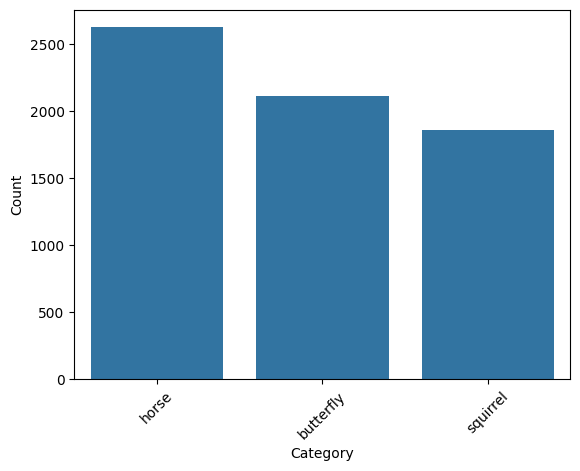

In [12]:
# Menghitung jumlah gambar di setiap kategori
categories = []
image_counts = []

for dir_name in os.listdir(base_dir):
    category_path = os.path.join(base_dir, dir_name)

    if os.path.isdir(category_path):
        img_count = len(os.listdir(category_path))
        categories.append(dir_name)
        image_counts.append(img_count)

display_category_counts(categories, image_counts)

### Data Preprocessing

In [13]:
augmentor = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [14]:
RESIZE_SHAPE = (256, 256)

def augment_image(image_path):
    image = load_img(image_path, target_size=RESIZE_SHAPE)
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    augmented_batch = augmentor.flow(image_array, batch_size=1)
    return next(augmented_batch)[0]

def export_image(image_array, output_path):
    final_image = array_to_img(image_array)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    final_image.save(output_path)

def augment_category_images(category, source_path, desired_total):
    existing_images = [
        os.path.join(source_path, img_name)
        for img_name in os.listdir(source_path)
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    current_total = len(existing_images)

    if current_total < desired_total:
        print(f"Mengaugmentasi kategori '{category}': {current_total} ➜ {desired_total}")
        additional_needed = desired_total - current_total

        for i in range(additional_needed):
            chosen_image = random.choice(existing_images)
            new_aug_image = augment_image(chosen_image)
            output_name = f"augmented_{i + current_total}.jpg"
            output_path = os.path.join(OUTPUT_DIR, category, output_name)
            export_image(new_aug_image, output_path)

    for index, image_path in enumerate(existing_images):
        output_name = f"original_{index}.jpg"
        output_path = os.path.join(OUTPUT_DIR, category, output_name)

        if not os.path.exists(output_path):
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            shutil.copy(image_path, output_path)

def prepare_dataset(input_dir, output_dir):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    category_dirs = [
        folder for folder in os.listdir(input_dir)
        if os.path.isdir(os.path.join(input_dir, folder))
    ]

    max_images = max(
        len([
            f for f in os.listdir(os.path.join(input_dir, cat))
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        for cat in category_dirs
    )

    for category in category_dirs:
        category_input_path = os.path.join(input_dir, category)
        category_output_path = os.path.join(output_dir, category)
        os.makedirs(category_output_path, exist_ok=True)

        current_count = len([
            f for f in os.listdir(category_input_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

        print(f"Memproses '{category}' dengan {current_count} gambar...")
        augment_category_images(category, category_input_path, max_images)

In [15]:
dataset_dir = 'raw-img'
OUTPUT_DIR = 'augmented_images'

prepare_dataset(dataset_dir, OUTPUT_DIR)

Memproses 'horse' dengan 2623 gambar...
Memproses 'butterfly' dengan 2112 gambar...
Mengaugmentasi kategori 'butterfly': 2112 ➜ 2623
Memproses 'squirrel' dengan 1862 gambar...
Mengaugmentasi kategori 'squirrel': 1862 ➜ 2623


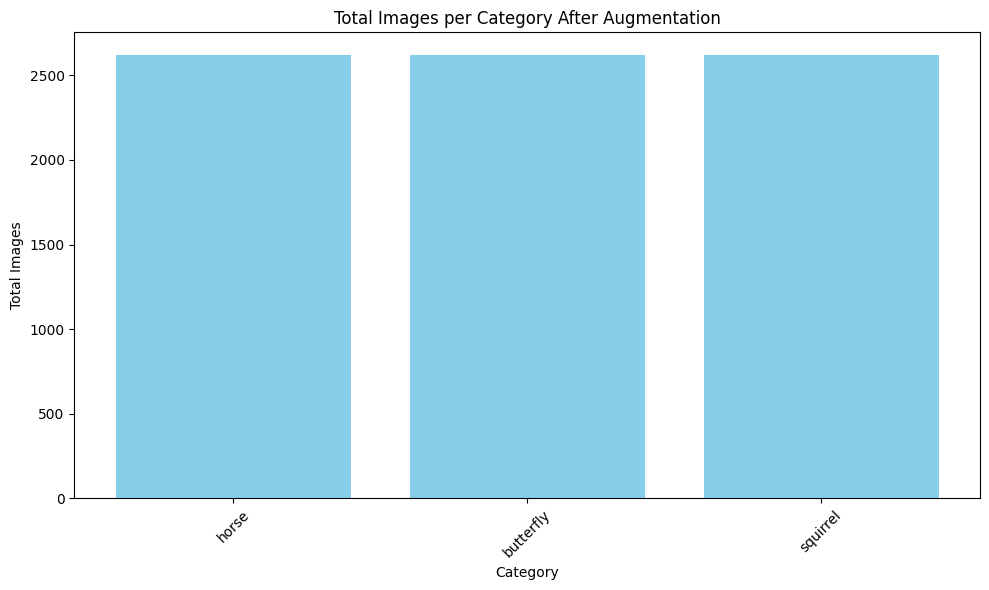

In [16]:
augmented_folder = 'augmented_images'
categories = os.listdir(augmented_folder)

category_labels = []
image_totals = []

for label in categories:
    label_path = os.path.join(augmented_folder, label)
    total_images = len(os.listdir(label_path))
    category_labels.append(label)
    image_totals.append(total_images)

plt.figure(figsize=(10, 6))
plt.bar(category_labels, image_totals, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Total Images')
plt.title('Total Images per Category After Augmentation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
aug_dir = 'augmented_images'

In [18]:
x_category = [name for name in os.listdir(aug_dir) if os.path.isdir(os.path.join(aug_dir, name))]

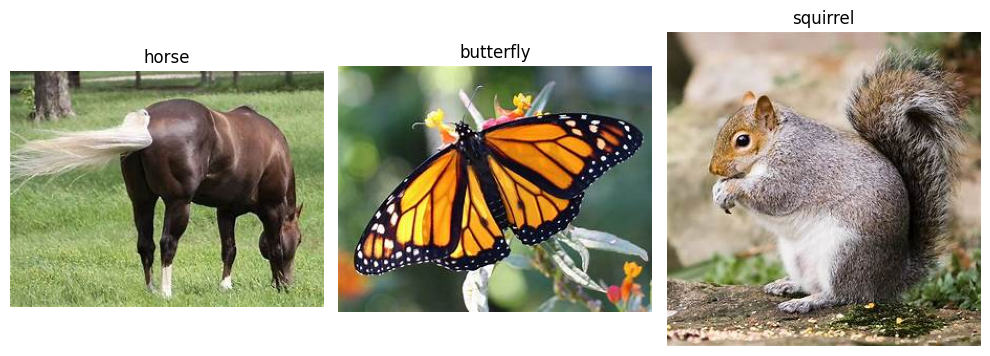

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
axes = axes.ravel()

for i, category in enumerate(x_category):
    folder_path = os.path.join(aug_dir, category)

    image_file = random.choice(os.listdir(folder_path))
    image_path = os.path.join(folder_path, image_file)

    img = Image.open(image_path)

    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### Split Dataset

In [20]:
def bagi_dataset(sumber_augmented, direktori_latih, direktori_uji, proporsi_latih=0.8):
    for folder in [direktori_latih, direktori_uji]:
        if os.path.exists(folder):
            shutil.rmtree(folder)
        os.makedirs(folder)

    daftar_kategori = [
        nama for nama in os.listdir(sumber_augmented)
        if os.path.isdir(os.path.join(sumber_augmented, nama))
    ]

    for kategori in daftar_kategori:
        path_kategori = os.path.join(sumber_augmented, kategori)
        daftar_gambar = [
            img for img in os.listdir(path_kategori)
            if img.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        random.shuffle(daftar_gambar)  #

        batas_split = int(len(daftar_gambar) * proporsi_latih)

        os.makedirs(os.path.join(direktori_latih, kategori), exist_ok=True)
        os.makedirs(os.path.join(direktori_uji, kategori), exist_ok=True)

        for gambar in daftar_gambar[:batas_split]:
            shutil.copy(
                os.path.join(path_kategori, gambar),
                os.path.join(direktori_latih, kategori, gambar)
            )

        for gambar in daftar_gambar[batas_split:]:
            shutil.copy(
                os.path.join(path_kategori, gambar),
                os.path.join(direktori_uji, kategori, gambar)
            )

In [21]:
direktori_sumber = 'augmented_images'
folder_train = 'split/train'
folder_test = 'split/test'

bagi_dataset(direktori_sumber, folder_train, folder_test, 0.8)

In [22]:
!rm -rf augmented_images/ raw-img/ translate.py sample_data/

In [23]:
augmentasi_latih = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmentasi_uji = ImageDataGenerator(
    rescale=1.0 / 255
)

generator_latih = augmentasi_latih.flow_from_directory(
    folder_train,
    target_size=(100, 100),
    class_mode='categorical'
)

generator_uji = augmentasi_uji.flow_from_directory(
    folder_test,
    target_size=(100, 100),
    class_mode='categorical'
)


Found 6294 images belonging to 3 classes.
Found 1575 images belonging to 3 classes.


## Modelling

In [24]:
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_val_datagen.flow_from_directory(
    'split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_val_datagen.flow_from_directory(
    'split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    'split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5037 images belonging to 3 classes.
Found 1257 images belonging to 3 classes.
Found 1575 images belonging to 3 classes.


In [25]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [27]:
def create_cnn_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

In [28]:
model = create_cnn_model(input_shape=(224, 224, 3), num_classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,012,995 (11.49 MB)

 Trainable params: 754,883 (2.88 MB)

 Non-trainable params: 2,258,112 (8.61 MB)

In [29]:
class CustomEarlyStopping(Callback):
    def __init__(self, target_accuracy=0.85):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if acc is not None and val_acc is not None:
            if acc >= self.target_accuracy and val_acc >= self.target_accuracy:
                print(f"\nTarget akurasi {self.target_accuracy*100}% tercapai pada epoch ke-{epoch+1}, menghentikan pelatihan.")
                self.model.stop_training = True

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
)
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    verbose=1,
    mode='max'
)

In [30]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)

In [31]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


In [32]:
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights_array))

history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[checkpoint, lr_scheduler, early_stop],
    class_weight=class_weights,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9549 - loss: 0.1257
Epoch 1: val_accuracy improved from -inf to 0.99111, saving model to best_model.h5


158/158 ━━━━━━━━━━━━━━━━━━━━ 34s 144ms/step - accuracy: 0.9551 - loss: 0.1253 - val_accuracy: 0.9911 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9961 - loss: 0.0131
Epoch 2: val_accuracy improved from 0.99111 to 0.99175, saving model to best_model.h5


158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9961 - loss: 0.0131 - val_accuracy: 0.9917 - val_loss: 0.0420 - learning_rate: 0.0010
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9920 - loss: 0.0228
Epoch 3: val_accuracy did not improve from 0.99175
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.9921 - loss: 0.0227 - val_accuracy: 0.9892 - val_loss: 0.0485 - learning_rate: 0.0010
Epoch 4/10
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9951 - loss: 0.0152
Epoch 4: val_accuracy improved from 0.99175 to 0.99238, saving model to best_model.h5


158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.9952 - loss: 0.0151 - val_accuracy: 0.9924 - val_loss: 0.0401 - learning_rate: 0.0010
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9990 - loss: 0.0028
Epoch 5: val_accuracy did not improve from 0.99238
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9990 - loss: 0.0028 - val_accuracy: 0.9879 - val_loss: 0.0767 - learning_rate: 0.0010
Epoch 6/10
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9984 - loss: 0.0130
Epoch 6: val_accuracy did not improve from 0.99238
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.9984 - loss: 0.0129 - val_accuracy: 0.9917 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 7/10
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9980 - loss: 0.0061
Epoch 7: val_accuracy did not improve from 0.99238

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.9980 - loss: 0.0061 - v

158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.9992 - loss: 0.0025 - val_accuracy: 0.9937 - val_loss: 0.0368 - learning_rate: 5.0000e-04
Epoch 9/10
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9993 - loss: 0.0027
Epoch 9: val_accuracy did not improve from 0.99365
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.9993 - loss: 0.0027 - val_accuracy: 0.9930 - val_loss: 0.0424 - learning_rate: 5.0000e-04
Epoch 10/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9998 - loss: 0.0012
Epoch 10: val_accuracy improved from 0.99365 to 0.99429, saving model to best_model.h5


158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.9943 - val_loss: 0.0429 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 10.


## Evaluasi dan Visualisasi

# Evaluasi Model

In [33]:
history_data = history_finetune

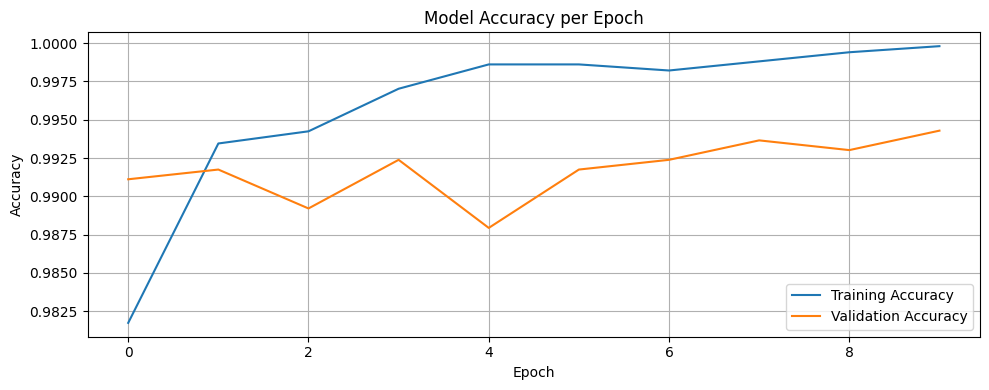

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(history_data.history['accuracy'], label='Training Accuracy')
plt.plot(history_data.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

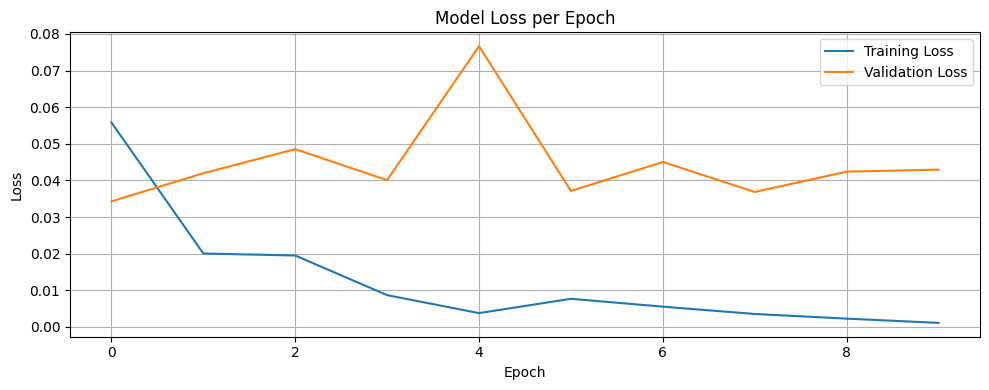

In [35]:
plt.figure(figsize=(10, 4))
plt.plot(history_data.history['loss'], label='Training Loss')
plt.plot(history_data.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Konversi Model

# TFJS

In [36]:
# Menonaktifkan Optimasi OneDNN
TF_ENABLE_ONEDNN_OPTS=0

In [42]:
!pip install tensorflowjs

In [38]:
!tensorflowjs_converter \
    --input_format=keras \
    best_model.h5 \
    tfjs_model

2025-05-04 06:50:53.584257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746341453.604054    2303 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746341453.611202    2303 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


# TF Lite

In [39]:
# Mengonversi model Keras ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
os.makedirs('tflite_model', exist_ok=True)

with open('tflite_model/model.tflite', 'wb') as file:
    file.write(tflite_model)

Saved artifact at '/tmp/tmpx18fs_1x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_310')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139114703790224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703790608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703791184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703790800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703789648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703792528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703792912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703793296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703793104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703789264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1391147037

In [40]:
!pip freeze > requirements.txt

In [41]:
from google.colab import files

model.export('saved_model')

!zip -r saved_model.zip saved_model/
!zip -r tfjs_model.zip tfjs_model/
!zip -r tflite_model.zip tflite_model/

files.download('saved_model.zip')
files.download('tfjs_model.zip')
files.download('tflite_model.zip')
files.download('best_model.h5')
files.download('requirements.txt')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_310')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139114703790224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703790608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703791184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703790800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703789648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703792528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703792912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703793296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703793104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703789264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114703794448

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

tflite_model_path = 'tflite_model/model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [49]:
y_pred = []
y_true = []

for i in range(len(test_generator)):
    images, labels = test_generator[i]
    y_true.extend(np.argmax(labels, axis=1))

    for img in images:
        img_input = np.expand_dims(img, axis=0).astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], img_input)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        pred_class = np.argmax(output)
        y_pred.append(pred_class)

In [50]:
# Label kelas dari generator
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.99      1.00      0.99       525
       horse       1.00      0.99      1.00       525
    squirrel       1.00      0.99      0.99       525

    accuracy                           0.99      1575
   macro avg       0.99      0.99      0.99      1575
weighted avg       0.99      0.99      0.99      1575

Confusion Matrix:
[[525   0   0]
 [  2 522   1]
 [  4   2 519]]


In [46]:
model = tf.keras.models.load_model('best_model.h5')

In [47]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step
Classification Report:
              precision    recall  f1-score   support

   butterfly       0.99      1.00      0.99       525
       horse       1.00      0.99      1.00       525
    squirrel       1.00      0.99      0.99       525

    accuracy                           0.99      1575
   macro avg       0.99      0.99      0.99      1575
weighted avg       0.99      0.99      0.99      1575

Confusion Matrix:
[[525   0   0]
 [  2 522   1]
 [  4   2 519]]
